In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import itertools
from itertools import groupby
import os

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"
%matplotlib inline

# 1. Data Load
### 전처리 width, height, input_channel 정의

In [4]:
from load_data import load_data,class_breakdown

In [5]:
#data_name ="EEG"
#data_name ="HAR"

data_name ="UWaveGestureLibraryAll"
trainx, testx,trainy,testy,batch_size = load_data(data_name =data_name)

Load data UWaveGestureLibraryAll
batch size:64
train data (3582, 945),(3582,)
test data (896, 945),(896,)


In [6]:
class_breakdown(trainy)
class_breakdown(testy)

Class=1, total=437, percentage=0.000
Class=2, total=452, percentage=0.000
Class=3, total=454, percentage=0.000
Class=4, total=450, percentage=0.000
Class=5, total=433, percentage=0.000
Class=6, total=449, percentage=0.000
Class=7, total=447, percentage=0.000
Class=8, total=460, percentage=0.000
Class=1, total=122, percentage=0.000
Class=2, total=108, percentage=0.000
Class=3, total=106, percentage=0.000
Class=4, total=110, percentage=0.000
Class=5, total=127, percentage=0.000
Class=6, total=111, percentage=0.000
Class=7, total=112, percentage=0.000
Class=8, total=100, percentage=0.000


In [7]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(trainy.flatten())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(testy.flatten())))
print("y train shape: {}".format(hot_encoded_y_train.shape))
print("y test shape: {}".format(hot_encoded_y_test.shape))

y train shape: (3582, 8)
y test shape: (896, 8)


## 데이터 정규화

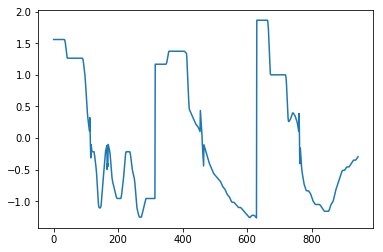

In [8]:
plt.plot(trainx[0])

In [9]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
trainx =TimeSeriesScalerMeanVariance().fit_transform(trainx)
testx =TimeSeriesScalerMeanVariance().fit_transform(testx)

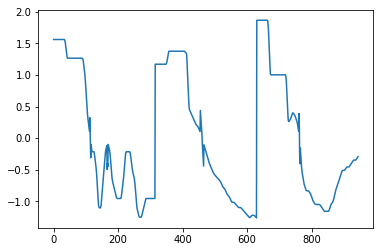

In [10]:
plt.plot(trainx[0])

In [11]:
trainX = trainx[:, np.newaxis, :]
trainY = hot_encoded_y_train

validX =testx[:len(testx)//2,np.newaxis,:]
validY= hot_encoded_y_test[:len(testx)//2]

testX = testx[len(testx)//2:,np.newaxis,:]
testY = hot_encoded_y_test[len(testx)//2:]

print ("trainX shape:{}".format(trainX.shape))
print ("trainY shape:{}".format(trainY.shape))
print ("validX shape:{}".format(validX.shape))
print ("validY shape:{}".format(validY.shape))
print ("testX shape:{}".format(testX.shape))
print ("testY shape:{}".format(testY.shape))

trainX shape:(3582, 1, 945, 1)
trainY shape:(3582, 8)
validX shape:(448, 1, 945, 1)
validY shape:(448, 8)
testX shape:(448, 1, 945, 1)
testY shape:(448, 8)


In [12]:
height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]

print ("height {}".format(height))
print ("width {}".format(width))
print ("input_channel {}".format(input_channel))

height 1
width 945
input_channel 1


# 2. Training condition 정의

In [13]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 300


std= 0.01
l_rate = 1e-5

In [14]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

# 3. model structure 정의

In [15]:
import tensorflow as tf

Couldn't import dot_parser, loading of dot files will not be possible.


In [18]:
import math
if data_name in ["HAR","EEG"]:
    conv1_channel = 32
    conv2_channel = 64
    conv3_channel = 128

    ###### conv1
    conv1_size = 7
    conv1_pad = int((conv1_size -1) /2)
    conv1_stride = 2

    pool1_size = 4
    pool1_pad = 0
    pool1_stride = 2

    ###### conv2
    conv2_size = 5
    conv2_pad = int((conv2_size -1) /2)
    conv2_stride = 1

    pool2_size = 4
    pool2_pad = 0
    pool2_stride = 2

    ###### conv3
    conv3_size = 3
    conv3_pad = int((conv3_size -1) /2)
    conv3_stride = 1

    pool3_size = 2
    pool3_pad = 0
    pool3_stride = 1
elif data_name in "UWaveGestureLibraryAll":
    conv1_channel = 32
    conv2_channel = 64
    conv3_channel = 128

    ###### conv1
    conv1_size = 15
    conv1_pad = int((conv1_size -1) /2)
    conv1_stride = 2

    pool1_size = 8
    pool1_pad = 0
    pool1_stride = 4

    ###### conv2
    conv2_size = 11
    conv2_pad = int((conv2_size -1) /2)
    conv2_stride = 1

    pool2_size = 4
    pool2_pad = 0
    pool2_stride = 2

    ###### conv3
    conv3_size = 7
    conv3_pad = int((conv3_size -1) /2)
    conv3_stride = 1

    pool3_size = 4
    pool3_pad = 0
    pool3_stride = 2

In [126]:
class conv3_basic_CNN:
    def __init__(self, featuremap1, featuremap2, featuremap3,
                 conv1_size, conv2_size, conv3_size,
                 conv1_stride, conv2_stride, conv3_stride, 
                 conv1_channel, conv2_channel, conv3_channel,
                 pool1_size, pool2_size, pool3_size,
                 pool1_stride, pool2_stride, pool3_stride,
                 std=0.01, batch_size=64,width=500, height =1, input_channel=3, 
                 nb_classes=2, l_rate =1e-6,
                 reuse = False):
        self.std=std
        self.batch_size=batch_size
        self.height = height
        self.width = width
        self.input_channel = input_channel
        self.l_rate = l_rate
        
        self.feature1 = featuremap1
        self.feature2 = featuremap2
        self.feature3 = featuremap3
        
        self.conv1_size = conv1_size
        self.conv2_size = conv2_size
        self.conv3_size = conv3_size
        
        self.conv1_stride = conv1_stride
        self.conv2_stride = conv2_stride
        self.conv3_stride = conv3_stride
        
        self.conv1_channel = conv1_channel
        self.conv2_channel = conv2_channel
        self.conv3_channel = conv3_channel
        
        self.pool1_size = pool1_size
        self.pool2_size = pool2_size
        self.pool3_size = pool3_size
        
        self.pool1_stride = pool1_stride
        self.pool2_stride = pool2_stride
        self.pool3_stride = pool3_stride
        
        self.nb_classes = nb_classes

        with tf.name_scope('Classifier'):
            self.y_ = tf.placeholder(tf.float32, [None, self.nb_classes], name='truth')
            self.x =tf.placeholder(tf.float32, [None, 1,trainX.shape[2],trainX.shape[3]],name='x')
            self.keep_prob1 = tf.placeholder(tf.float32,name="keep_probability1")
            self.keep_prob2 = tf.placeholder(tf.float32,name="keep_probability2")
            self.keep_prob3 = tf.placeholder(tf.float32,name="keep_probability3")
            
            self.unit_bool1 = tf.placeholder(tf.float32, [None, 1,self.feature1,self.conv1_channel], name="unit_bool1")
            self.unit_bool2 = tf.placeholder(tf.float32, [None, 1,self.feature2,self.conv2_channel], name="unit_bool2")
            self.unit_bool3 = tf.placeholder(tf.float32, [None, 1,self.feature3,self.conv3_channel], name="unit_bool3")

        # keep prob가 1보다 작으면, 드랍아웃을 한다는 의미
        #self.dropout_bool = True#tf.cond(self.keep_prob < 1.0, lambda: tf.constant(True), lambda: tf.constant(False))
        
        self.logits = self.build_model()

        # Define loss and optimizer, minimize the squared error
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.y, labels= self.y_)
        self.cost = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.l_rate).minimize(self.cost)

        self.correct_pred = tf.equal(tf.argmax(self.y, 1), tf.argmax(self.y_, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        init = tf.global_variables_initializer()

        # Launch the session
        self.session_conf = tf.ConfigProto()
        self.session_conf.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=self.session_conf)
        self.sess.run(init)

        self.saver = tf.train.Saver(max_to_keep=None)

    def build_model(self):
        xavier = tf.contrib.layers.xavier_initializer_conv2d()  
        self.conv1_weights = tf.get_variable(name="c1", initializer=xavier, shape=[1, self.conv1_size, trainX.shape[-1], conv1_channel])
        self.conv1_biases = tf.Variable(tf.zeros([conv1_channel]))
        self.conv2_weights = tf.get_variable(name="c2", initializer=xavier, shape=[1, self.conv2_size, self.conv1_channel, conv2_channel])
        self.conv2_biases = tf.Variable(tf.zeros([conv2_channel]))
        self.conv3_weights = tf.get_variable(name="c3", initializer=xavier, shape=[1, self.conv3_size, self.conv2_channel, conv3_channel])
        self.conv3_biases = tf.Variable(tf.zeros([conv3_channel]))
        self.fc1_weights = tf.Variable(tf.truncated_normal([1 * self.feature3  * self.conv3_channel, self.nb_classes], stddev=0.1))
        self.fc1_biases = tf.Variable(tf.zeros([self.nb_classes]))

        with tf.variable_scope('layer0'):
            #b, h, w, c
            self.reshaped_input = tf.reshape(self.x, [-1, 1, trainX.shape[2],trainX.shape[3]], name="absolute_input")
        # Convolutional Layer #1 and Pooling Layer #1
        with tf.variable_scope('layer1'):
            self.conv1 = tf.nn.conv2d(self.reshaped_input, self.conv1_weights, strides=[1, 1, self.conv1_stride, 1], padding='SAME')
            self.relu1 = tf.nn.relu(tf.nn.bias_add(self.conv1, self.conv1_biases))
            self.dropout1 = tf.nn.dropout(self.relu1, self.keep_prob1)
            self.pool1 =  tf.multiply(tf.nn.max_pool(self.dropout1, ksize=[1, 1, self.pool1_size, 1], strides=[1, 1, self.pool1_stride, 1],  padding='VALID'),
                                      self.unit_bool1)
            

        # Convolutional Layer #1 and Pooling Layer #2
        with tf.variable_scope('layer2'):
            self.conv2 = tf.nn.conv2d(self.pool1, self.conv2_weights, strides=[1, 1, self.conv2_stride, 1], padding='SAME')
            self.relu2 = tf.nn.relu(tf.nn.bias_add(self.conv2, self.conv2_biases))
            self.dropout2 = tf.nn.dropout(self.relu2, self.keep_prob2)
            self.pool2 =  tf.multiply(tf.nn.max_pool(self.dropout2, ksize=[1, 1, self.pool2_size, 1], strides=[1, 1, self.pool2_stride, 1],  padding='VALID'),
                                      self.unit_bool2)

        #Convolutional Layer #1 and Pooling Layer #3
        with tf.variable_scope('layer3'):
            self.conv3 = tf.nn.conv2d(self.pool2, self.conv3_weights, strides=[1, 1, self.conv3_stride, 1], padding='SAME')
            self.relu3 = tf.nn.relu(tf.nn.bias_add(self.conv3, self.conv3_biases))
            self.dropout3 = tf.nn.dropout(self.relu3, self.keep_prob3)
            self.pool3 =  tf.multiply(tf.nn.max_pool(self.dropout3, ksize=[1, 1, self.pool3_size, 1], strides=[1, 1, self.pool3_stride, 1],  padding='VALID'),
                                      self.unit_bool3)

        # Dense Layer with Relu
        with tf.variable_scope('layer4'):
            self.pool_shape = self.pool3.get_shape().as_list()
            self.reshaped = tf.reshape(self.pool3, [-1, self.pool_shape[1] * self.pool_shape[2] * self.pool_shape[3]])
            self.y = tf.add(tf.matmul(self.reshaped, self.fc1_weights), self.fc1_biases, name="absolute_output")
            self.prediction = tf.nn.softmax(self.y)
            
        return self.y


    def train(self, data, target):
        opt, cost ,acc = self.sess.run((self.optimizer,self.cost, self.accuracy ), 
                             feed_dict={self.y_: target,
                                        self.x: data,
                                       self.keep_prob1: 1.0,
                                       self.keep_prob2: 1.0,
                                       self.keep_prob3: 1.0,
                                       self.unit_bool1 : true_unit_bool1,
                                       self.unit_bool2 : true_unit_bool2,
                                       self.unit_bool3 : true_unit_bool3})
        return cost,acc

    def test(self, data, target):
        cost,acc = self.sess.run((self.cost,self.accuracy),
                             feed_dict={self.y_: target,
                                        self.x: data,
                                        self.keep_prob1: 1.0,
                                       self.keep_prob2: 1.0,
                                       self.keep_prob3: 1.0,
                                       self.unit_bool1 : true_unit_bool1,
                                       self.unit_bool2 : true_unit_bool2,
                                       self.unit_bool3 : true_unit_bool3})
        return cost,acc

    def get_output(self, output,data, keep_prob):
        output =  self.sess.run((output), feed_dict={self.x: data,self.keep_prob1: 1.0,
                                       self.keep_prob2: 1.0,
                                       self.keep_prob3: 1.0,
                                       self.unit_bool1 : true_unit_bool1,
                                       self.unit_bool2 : true_unit_bool2,
                                       self.unit_bool3 : true_unit_bool3})
        return output
    
    def predict(self, data, keep_prob):

        prediction =  self.sess.run((self.prediction), feed_dict={self.x: data,self.keep_prob1: 1.0,
                                       self.keep_prob2: 1.0,
                                       self.keep_prob3: 1.0,
                                       self.unit_bool1 : true_unit_bool1,
                                       self.unit_bool2 : true_unit_bool2,
                                       self.unit_bool3 : true_unit_bool3})
        return prediction

    def save(self, save_path='./model.ckpt'):
        saved_path = self.saver.save(self.sess, save_path)
        print("Model saved in file: %s"%saved_path)

    def load(self, load_path = './model.ckpt'):
        self.saver.restore(self.sess, load_path)
        print("Model restored")

    def terminate(self):
        self.sess.close()
        tf.reset_default_graph()

In [128]:
conv1_idx_list=[]
for conv1_idx in range(0,trainX.shape[2],conv1_stride):
    conv1_idx_list.append(np.arange(max(conv1_idx-(conv1_size//2),0), min(conv1_idx+(conv1_size//2) +1 ,trainX.shape[2])))

if conv1_idx < (trainX.shape[2]-1):
    for data_idx in np.arange(conv1_idx+1, trainX.shape[2]):
        conv1_idx_list.append(data_idx)
    
print(len(conv1_idx_list))



pool1_idx_list=[]
for pool1_idx in range(0,len(conv1_idx_list)-(pool1_size-1), pool1_stride):
    temp_idx = []
    for conv1_idx in np.arange(max(pool1_idx,0), min(pool1_idx+pool1_size ,len(conv1_idx_list))):
        temp_idx.extend(conv1_idx_list[conv1_idx])
    if set(temp_idx):
        pool1_idx_list.append(list(set(temp_idx)))
        
if (pool1_idx + pool1_size) < (len(conv1_idx_list)-1):
    temp_idx = []
    for conv1_idx in np.arange(pool1_idx+1, len(conv1_idx_list)):
        temp_idx.extend(conv1_idx_list[conv1_idx])
        pool1_idx_list.append(list(set(temp_idx)))
print(len(pool1_idx_list))


conv2_idx_list=[]
for conv2_idx in range(0,len(pool1_idx_list), conv2_stride):
    temp_idx = []
    for pool1_idx in np.arange(max(conv2_idx-(conv2_size//2),0), min(conv2_idx+(conv2_size//2) +1 ,len(pool1_idx_list))):
        temp_idx.extend(pool1_idx_list[pool1_idx])
    if set(temp_idx):
        conv2_idx_list.append(list(set(temp_idx)))

if conv2_idx < (len(pool1_idx_list)-1):
    print("add")
    temp_idx = []
    for pool1_idx in np.arange(conv2_idx+1, len(pool1_idx_list)):
        conv2_idx_list.append(pool1_idx_list[pool1_idx])
print(len(conv2_idx_list))




pool2_idx_list=[]
for pool2_idx in range(0,len(conv2_idx_list)-(pool2_size-1), pool2_stride):
    temp_idx = []
    for conv2_idx in np.arange(max(pool2_idx ,0), min(pool2_idx+pool2_size ,len(conv2_idx_list))):
        temp_idx.extend(conv2_idx_list[conv2_idx])
    pool2_idx_list.append(list(set(temp_idx)))

if (pool2_idx + pool2_size-1) < (len(conv2_idx_list)-1):
    print('add')
    temp_idx = []
    for conv2_idx in np.arange(pool2_idx+ pool2_size+1, len(conv2_idx_list)):
        pool2_idx_list.append(conv2_idx_list[conv2_idx])
print(len(pool2_idx_list))

conv3_idx_list=[]
for conv3_idx in range(0,len(pool2_idx_list), conv3_stride):
    temp_idx = []
    for pool2_idx in np.arange(max(conv3_idx-(conv3_size//2),0), min(conv3_idx+(conv3_size//2) +1 ,len(pool2_idx_list))):
        temp_idx.extend(pool2_idx_list[pool2_idx])
    if set(temp_idx):
        conv3_idx_list.append(list(set(temp_idx)))

if conv3_idx < (len(pool2_idx_list)-1):
    print("add")
    temp_idx = []
    for pool2_idx in np.arange(conv3_idx+1, len(pool3_idx_list)):
        conv3_idx_list.append(pool2_idx_list[pool2_idx])
print(len(conv3_idx_list))



pool3_idx_list=[]
for pool3_idx in range(0,len(conv3_idx_list)-(pool3_size-1), pool3_stride):
    temp_idx = []
    for conv3_idx in np.arange(max(pool3_idx ,0), min(pool3_idx+pool3_size ,len(conv3_idx_list))):
        temp_idx.extend(conv3_idx_list[conv3_idx])
    pool3_idx_list.append(list(set(temp_idx)))

if (pool3_idx + pool3_size-1) < (len(conv3_idx_list)-1):
    print('add')
    for conv3_idx in np.arange(pool3_idx+ pool3_size+1, len(conv3_idx_list)):
        pool3_idx_list.append(conv3_idx_list[conv3_idx])
print(len(pool3_idx_list))


473
117
117
add
57
57
add
27


In [129]:
pool1_pattern_len = np.max([len(x) for x in pool1_idx_list])
pool2_pattern_len = np.max([len(x) for x in pool2_idx_list])
pool3_pattern_len = np.max([len(x) for x in pool3_idx_list])

print("pool pattern length : pool1({}),pool2({}),pool3({})".format(pool1_pattern_len,
                                                                     pool2_pattern_len,
                                                                     pool3_pattern_len))

pool pattern length : pool1(29),pool2(133),pool3(277)


In [130]:
pool1_output_len = len(pool1_idx_list)
pool2_output_len = len(pool2_idx_list)
pool3_output_len = len(pool3_idx_list)

In [131]:
from numpy import unique
nb_classes =trainY.shape[1]
print (nb_classes)

8


<font color='red'> turn off 구조는 마지막 convolution layer activation output 에 weight를 elementwise multiply 구조.
train, test시에는 이 weight를 모두 1로 고정하며,
prdiction 시에는 convolution layer activation output에서 상위 T%를 turn off 시키며 accuracy의 변화가 A 이상인 경우를
threshold로 정하기 위해 이러한 모델 구조가 설정되었습니다.</font>

<font color='blue'> CNN_MC_dropout_last_conv_turnoff</font> 모델은 상위 T%의 output을 가지는 last convolution output을 0으로 turn off 시키는 구조입니다.

반면, <font color='blue'> CNN_MC_dropout_input_turnoff</font> 모델은 상위 T%의 output을 가지는 last convolution output에 매칭되는(하이라이트 되는 인풋)을 0으로 turn off 시키는 구조입니다.

In [132]:
pool1_output_len

117

In [133]:

tf.reset_default_graph()

In [134]:
#if 'MC_dropout_model' in globals()
try:
    MC_dropout_model.sess.close()
except:
    pass
tf.reset_default_graph()
MC_dropout_model = conv3_basic_CNN(featuremap1=pool1_output_len, featuremap2=pool2_output_len, featuremap3=pool3_output_len,
                                      conv1_size=conv1_size, conv2_size=conv2_size, conv3_size=conv3_size,
                                      conv1_channel=conv1_channel, conv2_channel=conv2_channel, conv3_channel=conv3_channel,
                                       conv1_stride=conv1_stride, conv2_stride=conv2_stride, conv3_stride=conv3_stride,
                                       pool1_size=pool1_size, pool2_size=pool2_size, pool3_size=pool3_size,
                                       pool1_stride=pool1_stride, pool2_stride=pool2_stride, pool3_stride=pool3_stride,
                                       
                                      height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)


In [135]:
print (MC_dropout_model.reshaped_input)

print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print (MC_dropout_model.pool1)

print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print (MC_dropout_model.pool2)
print ('[layer3] - MC dropout')
print (MC_dropout_model.conv3)
print (MC_dropout_model.relu3)
print (MC_dropout_model.dropout3)
print (MC_dropout_model.pool3)


print ('[layer4]')
print (MC_dropout_model.reshaped)
print (MC_dropout_model.y)

Tensor("layer0/absolute_input:0", shape=(?, 1, 945, 1), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/Conv2D:0", shape=(?, 1, 473, 32), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 473, 32), dtype=float32)
Tensor("layer1/dropout/mul:0", shape=(?, 1, 473, 32), dtype=float32)
Tensor("layer1/Mul:0", shape=(?, 1, 117, 32), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/Conv2D:0", shape=(?, 1, 117, 64), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 117, 64), dtype=float32)
Tensor("layer2/dropout/mul:0", shape=(?, 1, 117, 64), dtype=float32)
Tensor("layer2/Mul:0", shape=(?, 1, 57, 64), dtype=float32)
[layer3] - MC dropout
Tensor("layer3/Conv2D:0", shape=(?, 1, 57, 128), dtype=float32)
Tensor("layer3/Relu:0", shape=(?, 1, 57, 128), dtype=float32)
Tensor("layer3/dropout/mul:0", shape=(?, 1, 57, 128), dtype=float32)
Tensor("layer3/Mul:0", shape=(?, 1, 27, 128), dtype=float32)
[layer4]
Tensor("layer4/Reshape:0", shape=(?, 3456), dtype=float32)
Tensor("layer4/absolute_outp

# 4. Training

In [136]:
import time
import os
import numpy as np

In [137]:
save_path = './model/'+data_name
model_name = data_name+"_CNN_conv3_"+str(l_rate)+'_'+str(batch_size)
print (model_name)

UWaveGestureLibraryAll_CNN_conv3_1e-05_64


In [138]:
from training import get_batch

In [139]:
keep_prob =1.0

In [140]:
trainY.shape

(3582, 8)

In [141]:
for epoch in range(num_epochs):#range(num_epochs):##
    
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, nb_classes = nb_classes, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target)
        loss = loss1+loss
        acc = acc1+acc
        if np.isnan(loss):
            print ('error')
            break
    t_loss.append(loss/train_batches)
    t_acc.append(acc/train_batches)
    
    train_history.loc[epoch] = [epoch, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    if not os.path.exists(os.path.join(save_path, model_name)):
        os.mkdir( os.path.join(save_path, model_name))
    MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
    if(epoch+1)%val_freq ==0:
        acc=0
        loss = 0
        val_batches=0
        for batch in get_batch(X=validX, Y=validY, nb_classes = nb_classes, batch_size=batch_size):
            val_in, val_target = batch
            val_batches += 1.0 
            loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target)                                              
            loss = loss1+loss
            acc = acc1+acc
        
        v_acc.append(acc/val_batches)
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch] = [epoch, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
        print("  training loss:\t{:.6f}".format(t_loss[epoch]))
        print("  training acc:\t{:.3f}".format(t_acc[epoch]))
        print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
        print("  validation acc:\t{:.3f}".format(v_acc[epoch]))


INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/1.ckpt
  training loss:	2.164706
  training acc:	0.086
  validation loss:	2.053371
  validation acc:	0.128
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/2.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/2.ckpt
  training loss:	1.951911
  training acc:	0.247
  validation loss:	1.874967
  validation acc:	0.312
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/3.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/3.ckpt
  training loss:	1.777077
  trainin

INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/24.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/24.ckpt
  training loss:	0.262267
  training acc:	0.937
  validation loss:	0.261931
  validation acc:	0.930
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/25.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/25.ckpt
  training loss:	0.251493
  training acc:	0.940
  validation loss:	0.252577
  validation acc:	0.935
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/26.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/26.ckpt
  training loss:	0.241647
  t

INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/47.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/47.ckpt
  training loss:	0.135401
  training acc:	0.968
  validation loss:	0.148991
  validation acc:	0.958
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/48.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/48.ckpt
  training loss:	0.132705
  training acc:	0.968
  validation loss:	0.146619
  validation acc:	0.958
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/49.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/49.ckpt
  training loss:	0.130107
  t

INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/70.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/70.ckpt
  training loss:	0.091616
  training acc:	0.978
  validation loss:	0.114800
  validation acc:	0.964
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/71.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/71.ckpt
  training loss:	0.090238
  training acc:	0.978
  validation loss:	0.113890
  validation acc:	0.964
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/72.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/72.ckpt
  training loss:	0.088883
  t

INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/93.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/93.ckpt
  training loss:	0.065472
  training acc:	0.983
  validation loss:	0.100546
  validation acc:	0.964
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/94.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/94.ckpt
  training loss:	0.064585
  training acc:	0.983
  validation loss:	0.100135
  validation acc:	0.964
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/95.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/95.ckpt
  training loss:	0.063715
  t

INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/116.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/116.ckpt
  training loss:	0.047385
  training acc:	0.988
  validation loss:	0.090999
  validation acc:	0.969
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/117.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/117.ckpt
  training loss:	0.046707
  training acc:	0.988
  validation loss:	0.090682
  validation acc:	0.969
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/118.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/118.ckpt
  training loss:	0.0460

INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/139.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/139.ckpt
  training loss:	0.034231
  training acc:	0.993
  validation loss:	0.085687
  validation acc:	0.974
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/140.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/140.ckpt
  training loss:	0.033750
  training acc:	0.993
  validation loss:	0.085508
  validation acc:	0.974
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/141.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/141.ckpt
  training loss:	0.0332

INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/162.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/162.ckpt
  training loss:	0.024659
  training acc:	0.997
  validation loss:	0.083375
  validation acc:	0.974
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/163.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/163.ckpt
  training loss:	0.024297
  training acc:	0.997
  validation loss:	0.083309
  validation acc:	0.974
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/164.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/164.ckpt
  training loss:	0.0239

INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/185.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/185.ckpt
  training loss:	0.017384
  training acc:	0.998
  validation loss:	0.082600
  validation acc:	0.977
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/186.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/186.ckpt
  training loss:	0.017109
  training acc:	0.998
  validation loss:	0.082626
  validation acc:	0.974
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/187.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/187.ckpt
  training loss:	0.0168

INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/208.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/208.ckpt
  training loss:	0.011782
  training acc:	0.999
  validation loss:	0.083357
  validation acc:	0.979
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/209.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/209.ckpt
  training loss:	0.011570
  training acc:	0.999
  validation loss:	0.083410
  validation acc:	0.979
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/210.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/210.ckpt
  training loss:	0.0113

INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/231.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/231.ckpt
  training loss:	0.007743
  training acc:	0.999
  validation loss:	0.084864
  validation acc:	0.979
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/232.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/232.ckpt
  training loss:	0.007603
  training acc:	0.999
  validation loss:	0.084988
  validation acc:	0.979
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/233.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/233.ckpt
  training loss:	0.0074

INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/254.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/254.ckpt
  training loss:	0.005100
  training acc:	1.000
  validation loss:	0.088347
  validation acc:	0.979
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/255.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/255.ckpt
  training loss:	0.005007
  training acc:	1.000
  validation loss:	0.088504
  validation acc:	0.979
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/256.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/256.ckpt
  training loss:	0.0049

INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/277.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/277.ckpt
  training loss:	0.003335
  training acc:	1.000
  validation loss:	0.093206
  validation acc:	0.979
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/278.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/278.ckpt
  training loss:	0.003275
  training acc:	1.000
  validation loss:	0.093460
  validation acc:	0.979
INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/279.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/279.ckpt
  training loss:	0.0032

INFO:tensorflow:./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/300.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/300.ckpt
  training loss:	0.002167
  training acc:	1.000
  validation loss:	0.099267
  validation acc:	0.979


In [142]:
train_history.to_csv(os.path.join(save_path,model_name,  "history_train.csv"))
valid_history.to_csv(os.path.join(save_path,model_name,  "history_valid.csv"))

# 5.check the result

### with loss and accuracy graph

In [143]:
from visualization import plot_train_history

In [144]:
train_history = pd.read_csv(os.path.join(save_path,model_name,"history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path,model_name,"history_valid.csv"),index_col=0)

save ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/loss_graph.png
save ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/acc_graph.png


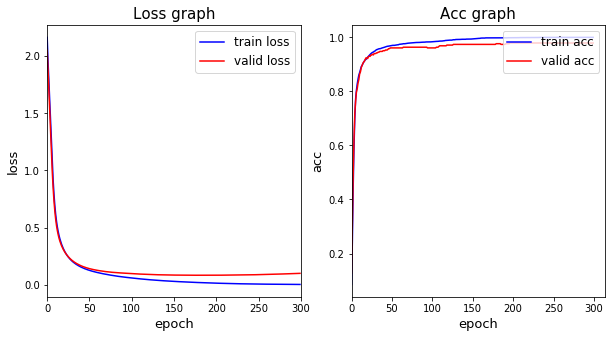

In [145]:
plot_train_history(train_df = train_history,
                   valid_df = valid_history,
                   save_path = os.path.join(save_path,model_name))

save ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/loss_graph.png
save ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/acc_graph.png


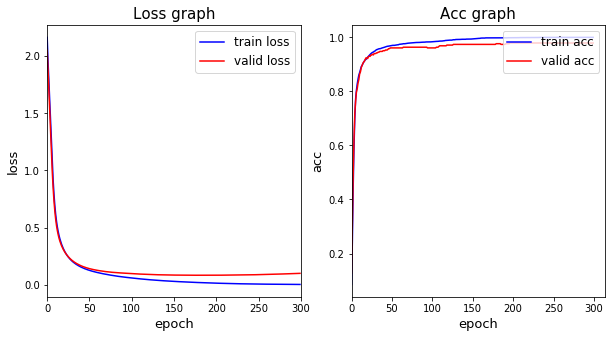

In [146]:
plot_train_history(train_df = train_history,
                   valid_df = valid_history,
                   save_path = os.path.join(save_path,model_name))

In [147]:
bestepoch = int(np.argmin(valid_history['loss'].values))
print( bestepoch)

error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))

MC_dropout_model.load(os.path.join(save_path,model_name,str(bestepoch)+'.ckpt'))

184
error: 0.0825997842476
INFO:tensorflow:Restoring parameters from ./model/UWaveGestureLibraryAll/UWaveGestureLibraryAll_CNN_conv3_1e-05_64/184.ckpt
Model restored


In [148]:
import glob
for epoch in [x+1 for x in range(num_epochs) if (x+1) !=bestepoch]:
    for filename in glob.glob(os.path.join(save_path,model_name,str(epoch)+".*")):
        os.remove(filename) 

### with confusion matrix

In [149]:
from visualization import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [150]:
class_list = np.unique(trainy, return_counts=False, return_index=True)[0].astype(int)

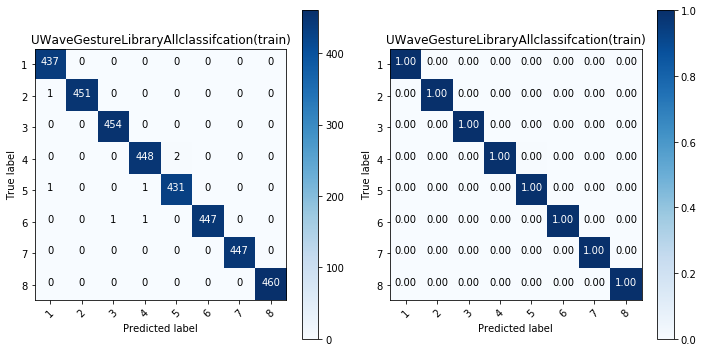

In [151]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(train)')

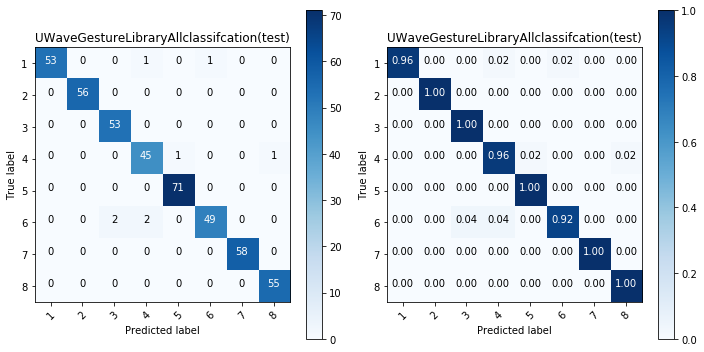

In [152]:
prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(target,prediction),                      
    classes=class_list,
    title=data_name+'classifcation(test)')

# MC LRP

In [153]:
from tensorflow.python.ops import nn_ops, gen_nn_ops

In [535]:
def lrp(F, lowest, highest, graph=None, return_flist=False):
    """
        Accepts a final output, and propagates back from there to compute LRP over a tensorflow graph. 
        Performs a Taylor Decomp at each layer to assess the relevances of each neuron at that layer
    """
    #Assumptions:
        #all conv strides are [1,1,1,1]
        #all pool strides are [1,2,2,1]
        #all pool/conv padding is SAME
        #only reshaping that happens is after a pool layer (pool -> fc) or a conv layer (conv -> fc)
    F_list = []
    traversed, graph, graph_dict, var_dict = get_traversed(graph=graph)
    for n in traversed:
        val_name = next(I for I in graph_dict[n].input if I in traversed).split("/read")[0] + ":0"
        X = graph.get_tensor_by_name(val_name)      
        if graph_dict[n].op == "MatMul":
            weight_name = next(I for I in graph_dict[n].input if not I in traversed).split("/read")[0] + ":0"
            W = var_dict[weight_name]
            if "layer0/absolute_input" in graph_dict[n].input:
                F = fprop_first(F, W, X, lowest, highest)
                F_list.append(F)
                break
            else:
                F = fprop(F, W, X) 
                F_list.append(F)
        elif graph_dict[n].op == "MaxPool" or graph_dict[n].op ==  "MaxPoolWithArgmax":
            if n ==u'layer3/MaxPool':
                strides=[1,1,pool3_stride,1]
                ksize=[1,1,pool3_size,1]
                print("MaxPool3 {},{}".format(ksize,strides))
            elif n ==u'layer2/MaxPool':
                strides=[1,1,pool2_stride,1]
                ksize=[1,1,pool2_size,1]
                print("MaxPool2 {},{}".format(ksize,strides))
            elif n ==u'layer1/MaxPool':
                strides=[1,1,pool1_stride,1]
                ksize=[1,1,pool1_size,1]
                print("MaxPool1 {},{}".format(ksize,strides))
            F = fprop_pool(F, X, strides= strides, ksize=ksize)     
            F_list.append(F)
        elif graph_dict[n].op == "Conv2D":
            weight_name = next(I for I in graph_dict[n].input if not I in traversed).split("/read")[0] + ":0"
            W = var_dict[weight_name]

            if "layer0/absolute_input" in graph_dict[n].input:
                print("layer1/Conv2D {}".format([1,1,conv1_stride,1]))
                F = fprop_conv_first(F, W, X, lowest, highest,strides = [1,1,conv1_stride,1])
                #F = fprop_conv_first2(F, W, X,strides = [1,1,conv1_stride,1])
                F_list.append(F)
                break
            else:
                if u'layer3/Conv2D' == n:
                    strides = [1,1,conv3_stride,1]
                    print("layer3/Conv2D {}".format(strides))
                elif u'layer2/Conv2D' == n:
                    strides = [1,1,conv2_stride,1]
                    print("layer2/Conv2D {}".format(strides))
                
                F = fprop_conv(F, W, X, strides = strides) 
                F_list.append(F)
    if return_flist:
        return F_list
    else:
        return F

def get_traversed(graph = None):
    #Get the graph and graph traversal
    graph = tf.get_default_graph() if graph is None else graph
    graph_dict = {node.name:node for node in graph.as_graph_def().node}
    var_dict = {v.name:v.value() for v in tf.get_collection(tf.GraphKeys.VARIABLES)}
    return traverse(graph_dict["layer4/absolute_output"], [], graph_dict), graph, graph_dict, var_dict


def traverse(node, L, graph_dict):
    #Depth First Search the Network Graph
    L.append(node.name)
    if "layer0/absolute_input" in node.name:
        return L
    inputs = node.input
    for nodename in inputs:
        if not traverse(graph_dict[nodename], L, graph_dict) is None:
            return L
    return None

def fprop_first(F, W, X, lowest, highest):
    #Propagate from last feedforward layer to input
    W,V,U = W,tf.maximum(0.0,W), tf.minimum(0.0,W)
    X,L,H = X, X*0+lowest, X*0+highest

    Z = tf.matmul(X, W)-tf.matmul(L, V)-tf.matmul(H, U)+1e-9
    print(Z.shape)
    S = F/Z
    print(S.shape)
    F = X*tf.matmul(S,tf.transpose(W))-L*tf.matmul(S, tf.transpose(V))-H*tf.matmul(S,tf.transpose(U))
    print(F.shape)
    return F

def fprop(F, W, X):
    #Propagate over feedforward layer
    V = tf.maximum(0.0, W)
    
    Z = tf.matmul(X, V)+1e-9;
    S = F/Z
    C = tf.matmul(S, tf.transpose(V))        
    F = X*C
    return F

def fprop_conv_first(F, W, X, lowest, highest, strides=None, padding='SAME'):
    #Propagate from last conv layer to input
    strides = [1, 1, 1, 1] if strides is None else strides

    Wn = tf.minimum(0.0, W)
    Wp = tf.maximum(0.0, W)
    
    print(Wp.shape)

    X, L, H = X, X*0+lowest, X*0+highest

    c  = tf.nn.conv2d(X, W, strides, padding)
    cp = tf.nn.conv2d(H, Wp, strides, padding)
    cn = tf.nn.conv2d(L, Wn, strides, padding)
    Z = c - cp - cn + 1e-9
    print(Z.shape)
    S = F/Z
    print(S.shape)
    g  = nn_ops.conv2d_backprop_input(tf.shape(X), W,  S, strides, padding)
    gp = nn_ops.conv2d_backprop_input(tf.shape(X), Wp, S, strides, padding)
    gn = nn_ops.conv2d_backprop_input(tf.shape(X), Wn, S, strides, padding)
    print(g.shape)
    F = X*g - L*gp - H*gn
    
    return F

def fprop_conv_first2(F, W, X, strides=None, padding='SAME'):
    #Propagate from last conv layer to input

    S = F/tf.multiply(W,W)
    print(S.shape)
    g  = nn_ops.conv2d_backprop_input(tf.shape(X), W,  S, strides, padding)
    print(g.shape)

    F = X*g
    
    return F


def fprop_conv(F, W, X, strides=None, padding='SAME'):
    #Propagate over conv layer
    
    xshape = X.get_shape().as_list()
    fshape = F.get_shape().as_list()

    if len(xshape) != len(fshape):
        F = tf.reshape(F, (-1, xshape[1], xshape[2], fshape[-1]/(xshape[1]*xshape[2])))
    strides = [1, 1, 1, 1] if strides is None else strides
        
    W = tf.maximum(0.0, W)

    Z = tf.nn.conv2d(X, W, strides, padding) + 1e-9 
    S = F/Z
    
    C = nn_ops.conv2d_backprop_input(tf.shape(X), W,  S, strides, padding)

    F = X*C
    return F

def fprop_pool(F, X, strides=None, ksize=None, padding='VALID'):
    #Propagate over pool layer
    xshape = X.get_shape().as_list()
    fshape = F.get_shape().as_list()
    if len(xshape) != len(fshape):
        F = tf.reshape(F, (-1, xshape[1], fshape[1]//xshape[3], xshape[3]))
    ksize = [1, 2, 2, 1]  if ksize is None else ksize
    strides = [1, 2, 2, 1]  if strides is None else strides
    
    Z = tf.nn.max_pool(X, strides=strides, ksize=ksize, padding=padding) + 1e-9
    S = F / Z
    C = gen_nn_ops._max_pool_grad(X, Z, S, ksize, strides, padding)    
    F = X*C

    print (F.get_shape().as_list())
    
    return F


def visualize(im_list, xval):
    #Visualize the LRPs
    for i in range(len(im_list[0])):
        plt.figure()
        plt.subplot(1,1+len(im_list),1)
        plt.title("Image")
        plt.imshow(xval[i])
        
        for j in range(len(im_list)):
            plt.subplot(1,1+len(im_list),2+j)
            plt.title("LRP for network {}".format(j))
            I = np.mean(np.maximum(im_list[j][i], 0), -1)
            I = np.minimum(I, np.percentile(I, 99))
            I = I/np.max(I)
            print ("np.linalg.norm(I)", np.linalg.norm(I))
            plt.imshow(I, cmap="gray")

        plt.show()
    return im_list


In [530]:
from matplotlib.pyplot import cm

# original LRP

In [546]:
F_list = lrp(MC_dropout_model.y*MC_dropout_model.y_, -1, 1, return_flist=True)

MaxPool3 [1, 1, 4, 1],[1, 1, 2, 1]
[None, 1, 57, 128]
layer3/Conv2D [1, 1, 1, 1]
MaxPool2 [1, 1, 4, 1],[1, 1, 2, 1]
[None, 1, 117, 64]
layer2/Conv2D [1, 1, 1, 1]
MaxPool1 [1, 1, 8, 1],[1, 1, 4, 1]
[None, 1, 473, 32]
layer1/Conv2D [1, 1, 2, 1]
(1, 15, 1, 32)
(?, 1, 473, 32)
(?, 1, 473, 32)
(?, 1, 945, 1)


In [547]:
import random
random.seed(1003)

In [548]:
from sklearn.preprocessing import MinMaxScaler

In [549]:
data_idx, input_channel =random.sample(range(len(trainX)),1),0

In [550]:
whole_lrp_score = F_list[-1].eval(session=MC_dropout_model.sess, feed_dict = {MC_dropout_model.x: trainX[data_idx].reshape(-1,1,trainX.shape[2],trainX.shape[3]), 
                                                                        MC_dropout_model.y_:trainY[data_idx].reshape(-1,nb_classes),
                                                                        MC_dropout_model.keep_prob1 :1.0,
                                                                        MC_dropout_model.keep_prob2 :1.0,
                                                                        MC_dropout_model.keep_prob3 :1.0,
                                                                        MC_dropout_model.unit_bool1: true_unit_bool1,
                                                                        MC_dropout_model.unit_bool2: true_unit_bool2,
                                                                        MC_dropout_model.unit_bool3: true_unit_bool3})

scaler = MinMaxScaler(feature_range=(0,1))

whole_lrp_score = scaler.fit_transform(whole_lrp_score.reshape(-1,1))

(-10, 955)

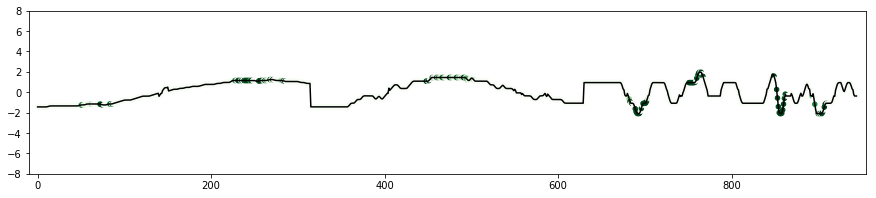

In [572]:
fig = plt.figure(figsize=(15,3))
ax = plt.subplot(1,1,1)
ax.plot(trainX[data_idx,0,:,input_channel].T,color='black')
ax.scatter(range(0,trainX.shape[2]),trainX[data_idx,0,:,input_channel],c = whole_lrp_score.squeeze().T,s=20,cmap=cm.Greens,vmin=0,vmax=0.1 )

ax.set_ylim(-8,8)
ax.set_xlim([0-10,int(trainX.shape[2])+10])

# MC unit LRP

In [552]:
false_unit_bool1 = np.zeros(pool1_output_len * conv1_channel).reshape(-1,1,pool1_output_len, conv1_channel)
false_unit_bool2 = np.zeros(pool2_output_len * conv2_channel).reshape(-1,1,pool2_output_len, conv2_channel)
false_unit_bool3 = np.zeros(pool3_output_len * conv3_channel).reshape(-1,1,pool3_output_len, conv3_channel)

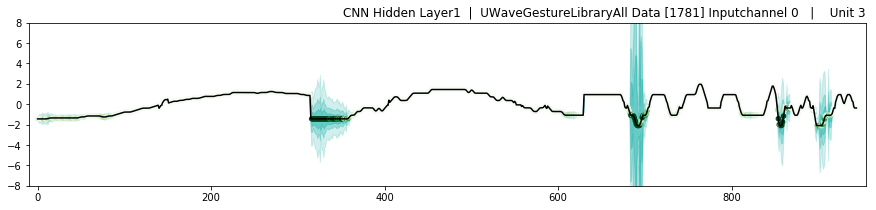

In [573]:
dropout_imlist=[]
unit=3
mc_num=300
for mc_idx in range(mc_num):
    false_unit_bool1[:,:,:,unit]=1.0
    unit_lrp_score =  F_list[-1].eval(session=MC_dropout_model.sess, feed_dict = {MC_dropout_model.x: trainX[data_idx].reshape(-1,1,trainX.shape[2],trainX.shape[3]), 
                                                                        MC_dropout_model.y_:trainY[data_idx].reshape(-1,nb_classes),
                                                                        MC_dropout_model.keep_prob1 :0.5,
                                                                        MC_dropout_model.keep_prob2 :1.0,
                                                                        MC_dropout_model.keep_prob3 :1.0,
                                                                        MC_dropout_model.unit_bool1: false_unit_bool1,
                                                                        MC_dropout_model.unit_bool2: true_unit_bool2,
                                                                        MC_dropout_model.unit_bool3: true_unit_bool3})
    dropout_imlist.append(unit_lrp_score)
uncertainty = np.asarray(dropout_imlist).std(axis=0)
mean = np.abs(np.asarray(dropout_imlist).mean(axis=0))

fig = plt.figure(figsize=(15,3))
ax = plt.subplot(1,1,1)
error = uncertainty.T[input_channel].squeeze()
#normalized_mean = scaler.fit_transform(mean.T[input_channel].reshape(-1,1))
ax.fill_between(np.arange(0,trainX.shape[2]), (trainX[data_idx,0,:,input_channel].squeeze()-5*error), (trainX[data_idx,0,:,input_channel].squeeze()+5*error), color='lightseagreen', alpha=0.4)
ax.fill_between(np.arange(0,trainX.shape[2]), (trainX[data_idx,0,:,input_channel].squeeze()-10*error), (trainX[data_idx,0,:,input_channel].squeeze()+10*error),  color='lightseagreen', alpha=0.3)
ax.fill_between(np.arange(0,trainX.shape[2]), (trainX[data_idx,0,:,input_channel].squeeze()-20*error), (trainX[data_idx,0,:,input_channel].squeeze()+20*error),  color='lightseagreen', alpha=0.2)

ax.plot(trainX[data_idx,0,:,input_channel].T,color='black')
ax.scatter(range(0,trainX.shape[2]),trainX[data_idx,0,:,input_channel],c = mean,s=20, cmap=cm.Greens,vmin=0,vmax=0.1)



ax.set_ylim(-8,8)
ax.set_xlim([0-10,int(trainX.shape[2])+10])
ax.set_title( "CNN Hidden Layer1  |  {} Data {} Inputchannel {}   |    Unit {}".format(data_name, data_idx,input_channel, unit), loc='right')